## **1. Importación de librerias y datos**

In [23]:
import pandas as pd
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

In [24]:
df_unificado = pd.read_excel('DatosCacao_multivariado.xlsx')
df_total = df_unificado.copy()

train_size = int(len(df_unificado) * 0.8)
test_size = len(df_unificado) - train_size

df_unificado = df_unificado.iloc[:-test_size]
df_unificado.drop(columns=["Fecha"], inplace=True)

print(df_unificado.tail())

      COP/kg      TRM  COP/kg (internacional)  Inflacion  COP/kg (futuro)
100  34900.8  4401.98                46997.39       5.20         46319.09
101  34633.5  4355.51                46596.51       5.22         46450.08
102  34229.2  4343.48                44717.30       5.22         44801.56
103  33817.8  4344.27                47131.29       5.22         47574.84
104  33831.3  4188.46                46874.52       5.22         47202.56


Debido a que las series no son estacionarias, se hace una diferenciación para volverlas **estacionarias** (como lo pide el modelo VAR).

In [25]:
df_diff = df_unificado.diff().dropna()
df_diff.head()

,COP/kg,TRM,COP/kg (internacional),Inflacion,COP/kg (futuro)
2,68.6,-191.67,-613.49,0.00,-694.67
3,49.2,-62.35,-251.12,0.00,-324.63
4,240.0,-83.14,-56.19,0.00,-105.73
5,37.8,121.24,57.34,0.03,140.22
6,66.7,107.99,469.60,0.00,482.23


## **2. Aplicación del modelo a los datos**

In [26]:
# Crear el modelo VAR
model = VAR(df_diff)

# Selección del rezago óptimo (AIC, BIC, HQIC, FPE)
lag_order_results = model.select_order(maxlags=12)
print(lag_order_results.summary())

# Elegir el rezago con AIC mínimo para este caso
best_lag = lag_order_results.aic
print(f"Mejor rezago según AIC: {best_lag}")

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        47.32      47.46*   3.552e+20       47.37
1       46.93*       47.76  2.416e+20*      47.27*
2        47.08       48.59   2.804e+20       47.69
3        47.16       49.37   3.100e+20       48.06
4        47.30       50.20   3.651e+20       48.47
5        47.18       50.76   3.345e+20       48.62
6        47.41       51.68   4.460e+20       49.13
7        47.44       52.41   5.056e+20       49.45
8        47.63       53.28   6.852e+20       49.91
9        47.89       54.24   1.052e+21       50.45
10       47.59       54.63   9.671e+20       50.43
11       47.48       55.20   1.153e+21       50.59
12       47.38       55.80   1.553e+21       50.78
--------------------------------------------------
Mejor rezago según AIC: 1


c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [27]:
var_model = model.fit(best_lag)
print(var_model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 11, Sep, 2025
Time:                     20:08:49
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    47.3329
Nobs:                     102.000    HQIC:                   46.8735
Log likelihood:          -3068.26    FPE:                1.66503e+20
AIC:                      46.5609    Det(Omega_mle):     1.25113e+20
--------------------------------------------------------------------
Results for equation COP/kg
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                           146.363144       158.359700            0.924           0.355
L1.COP/kg                        -0.113769         0.119801           -0.950           0.342
L1.TRM     

In [28]:
# Número de pasos a predecir
n_steps = test_size

forecast = var_model.forecast(df_diff.values[-best_lag:], steps=n_steps)
forecast_df = pd.DataFrame(forecast, 
                           index=pd.date_range(start=df_diff.index[-1], periods=n_steps+1, freq="W")[1:], 
                           columns=df_diff.columns)

print(forecast_df.head())

                                   COP/kg       TRM  COP/kg (internacional)  \
1970-01-11 00:00:00.000000104  414.858160 -1.587180              525.365383   
1970-01-18 00:00:00.000000104  243.610747 -7.001180              374.983008   
1970-01-25 00:00:00.000000104  246.290651 -3.161658              326.638334   
1970-02-01 00:00:00.000000104  217.211523 -5.246742              334.817157   
1970-02-08 00:00:00.000000104  229.183737 -4.861969              341.744783   

                               Inflacion  COP/kg (futuro)  
1970-01-11 00:00:00.000000104  -0.077912       598.151711  
1970-01-18 00:00:00.000000104  -0.081450       328.154864  
1970-01-25 00:00:00.000000104  -0.075649       337.271136  
1970-02-01 00:00:00.000000104  -0.080068       329.684587  
1970-02-08 00:00:00.000000104  -0.078323       342.752633  


In [29]:
# Tomamos el último valor real en niveles
last_obs = df_unificado.iloc[-1]

# Reconstruimos los niveles sumando acumulativamente las diferencias
forecast_levels = forecast_df.cumsum() + last_obs.values

forecast_levels = pd.DataFrame(forecast_levels, 
                               index=forecast_df.index, 
                               columns=df_unificado.columns)

print(forecast_levels.head())

                                     COP/kg          TRM  \
1970-01-11 00:00:00.000000104  34246.158160  4186.872820   
1970-01-18 00:00:00.000000104  34489.768907  4179.871640   
1970-01-25 00:00:00.000000104  34736.059557  4176.709982   
1970-02-01 00:00:00.000000104  34953.271081  4171.463240   
1970-02-08 00:00:00.000000104  35182.454817  4166.601271   

                               COP/kg (internacional)  Inflacion  \
1970-01-11 00:00:00.000000104            47399.885383   5.142088   
1970-01-18 00:00:00.000000104            47774.868391   5.060637   
1970-01-25 00:00:00.000000104            48101.506725   4.984989   
1970-02-01 00:00:00.000000104            48436.323882   4.904921   
1970-02-08 00:00:00.000000104            48778.068666   4.826598   

                               COP/kg (futuro)  
1970-01-11 00:00:00.000000104     47800.711711  
1970-01-18 00:00:00.000000104     48128.866575  
1970-01-25 00:00:00.000000104     48466.137712  
1970-02-01 00:00:00.000000104     

## **3. Visualización de los resultados del forecast**

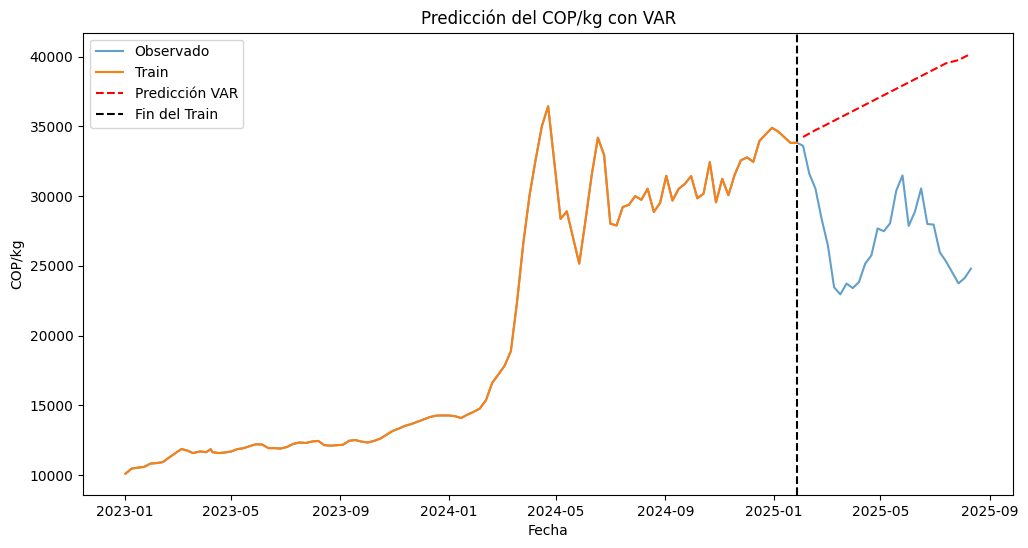

In [30]:
forecast_index = df_total['Fecha'].iloc[train_size:].reset_index(drop=True)
forecast_levels.index = pd.to_datetime(forecast_index)
train_dates = df_total['Fecha'].iloc[:train_size].reset_index(drop=True)

var_name = "COP/kg"  # cambia según variable de interés


plt.figure(figsize=(12,6))

# Serie observada completa (train + test reales)
plt.plot(df_total['Fecha'], df_total[var_name], label="Observado", color='C0', alpha=0.7)

# Resaltar la porción de entrenamiento (mismatching indices resuelto usando train_dates)
plt.plot(train_dates, df_unificado[var_name].values[:len(train_dates)], label="Train", color='C1')

# Forecast (con índice ya reasignado)
plt.plot(forecast_levels.index, forecast_levels[var_name], label="Predicción VAR", color="red", linestyle="--")

# Línea vertical que marca fin del train
plt.axvline(train_dates.iloc[-1], color='k', linestyle='--', label='Fin del Train')
plt.title(f"Predicción del {var_name} con VAR")
plt.xlabel("Fecha")
plt.ylabel(var_name)
plt.legend()
plt.show()


## **4. Análisis de impulso-respuesta (IRF)**

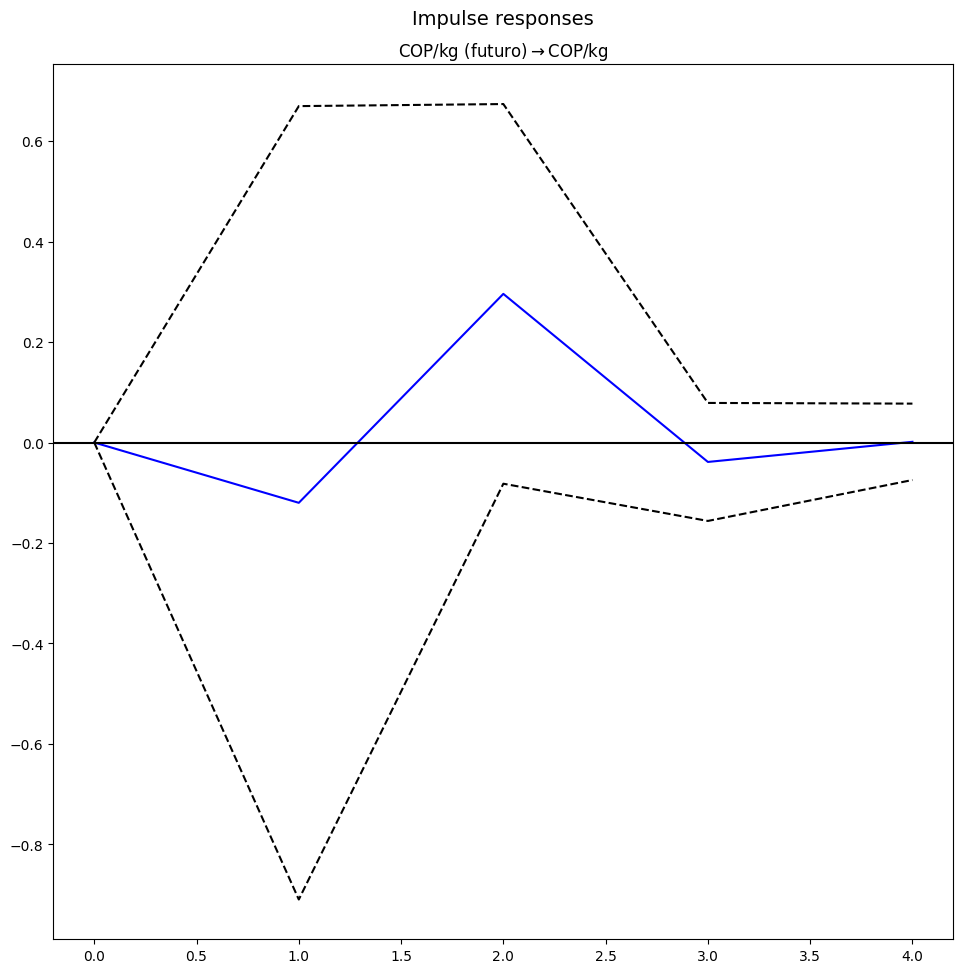

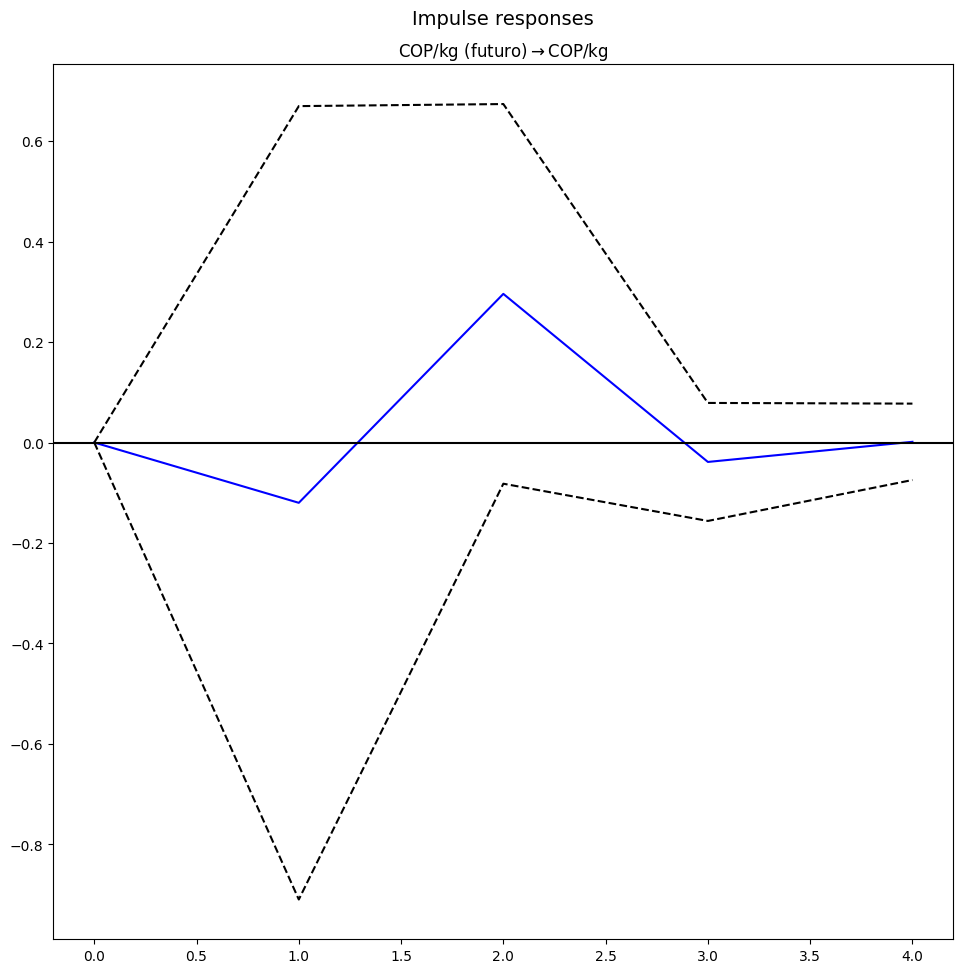

In [31]:
target = "COP/kg"   # variable de interés
shock = "COP/kg (futuro)"  # variable que genera el shock

irf.plot(response=target, impulse=shock, orth=False)

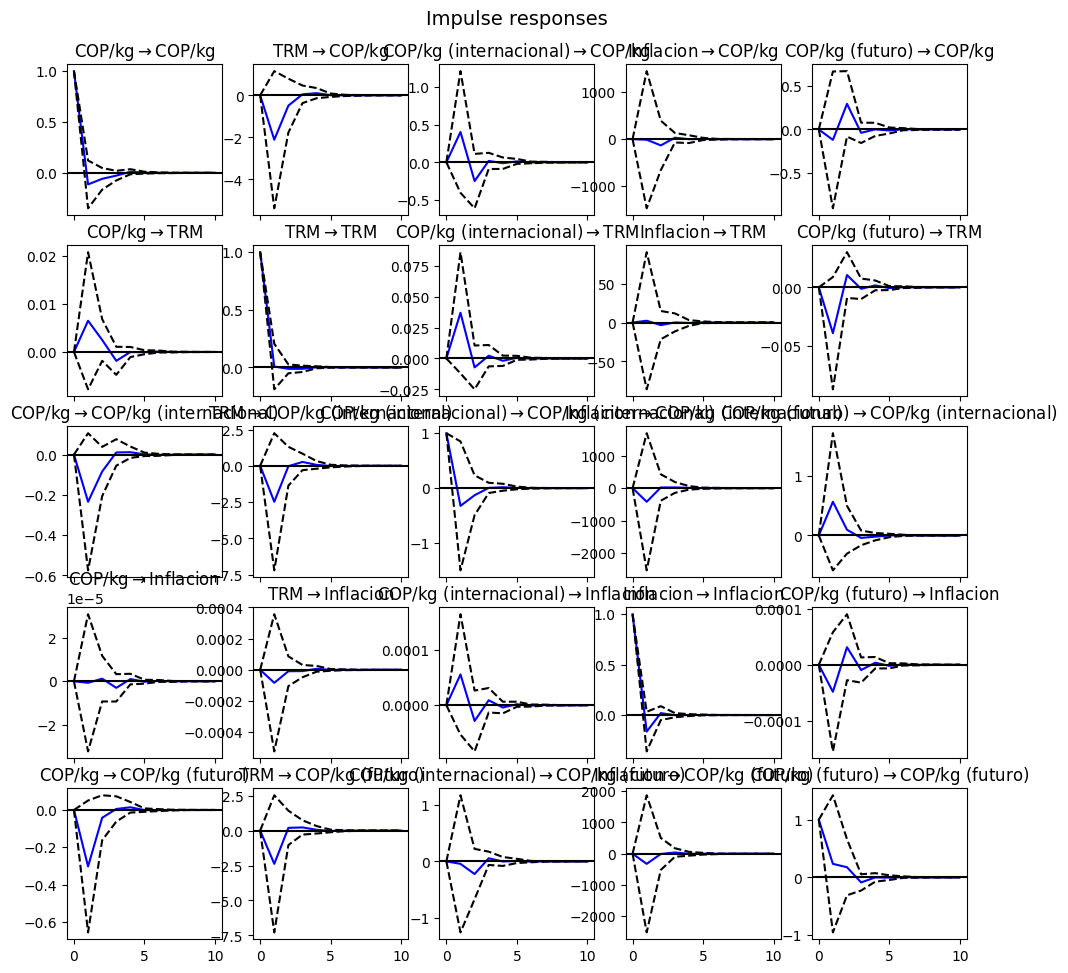

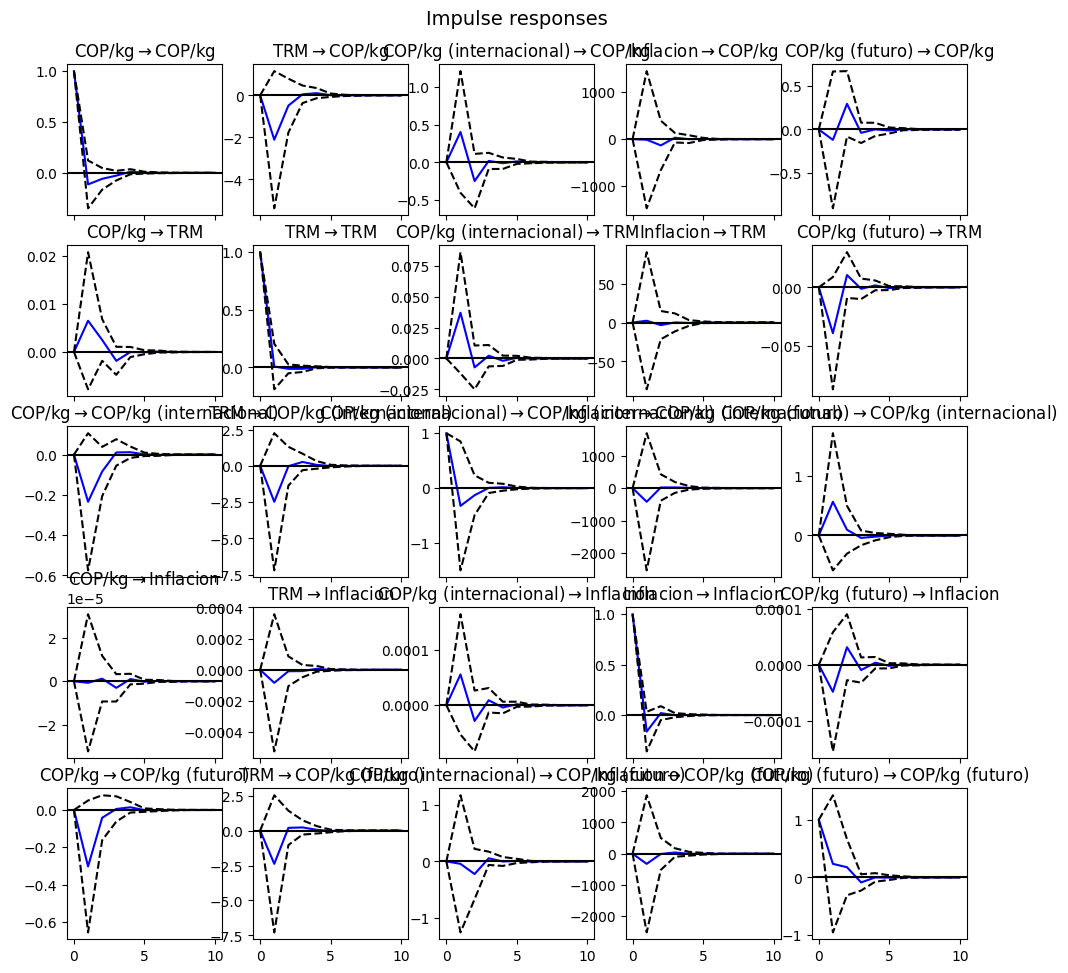

In [32]:
# Horizonte de predicción del shock
irf = var_model.irf(10)

# Graficar respuesta de todas las variables
irf.plot(orth=False)